In [158]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from patsy import dmatrices

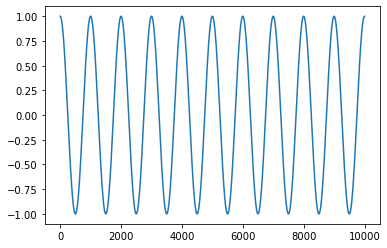

In [159]:
wave = np.genfromtxt('babes/wave.csv', delimiter=',')
plt.plot(wave)

n = wave.shape[0]
# n = 4

In [160]:
sp = np.fft.fft(wave, n)
freq = np.fft.fftfreq(n)
sp

array([1.        +0.j        , 1.0100989 +0.00031733j,
       1.04165771+0.00065449j, ..., 1.09887871-0.00103567j,
       1.04165771-0.00065449j, 1.0100989 -0.00031733j])

<AxesSubplot:>

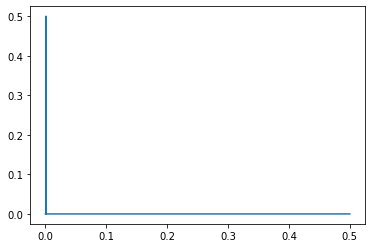

In [161]:
fft = pd.Series(np.round(sp.real/n, 2) ,index= freq) # dividing by length gives probability of that tone occuring
fft = fft.iloc[:(n//2)]
fft.plot()

In [163]:
fft.sort_values(ascending= False)

0.0010    0.5
0.3340   -0.0
0.3338   -0.0
0.3337   -0.0
0.3336   -0.0
         ... 
0.1667   -0.0
0.1666   -0.0
0.1665   -0.0
0.1664   -0.0
0.4999   -0.0
Length: 5000, dtype: float64

In [149]:
_ = fft[fft.index >= 0]
_.iloc[np.where(_.values != 0)]

0.0100    0.50
0.0101   -0.01
dtype: float64

In [144]:
fft = fft[fft.index >= 0]
fft = fft.iloc[np.where(fft.values != 0)].index.values
fft

array([0.01  , 0.0101])